In [55]:
import os
import jams
import re
from collections import Counter

import matplotlib.pyplot as plt
import mir_eval
import numpy as np

In [52]:
# Function to extract chord types from a chord label
def plot_chord_type_distribution(folder_path):
    def extract_chord_type(chord_label):
        match = re.match(r"([a-zA-Z]+)(\d*.*)", chord_label)
        if match:
            return match.group(1)
        return chord_label

    # Counter to store chord type frequencies
    chord_type_counter = Counter()

    # Iterate through all .jams files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jams"):
            file_path = os.path.join(folder_path, file_name)
            jam = jams.load(file_path)

            # Extract chord annotations
            for annotation in jam.search(namespace="chord"):
                for obs in annotation.data:
                    chord_type = extract_chord_type(obs.value)
                    chord_type_counter[chord_type] += 1

    # Plot the histogram
    chord_types = list(chord_type_counter.keys())
    frequencies = list(chord_type_counter.values())

    plt.figure(figsize=(12, 6))
    plt.bar(chord_types, frequencies, color="skyblue")
    plt.xlabel("Chord Types")
    plt.ylabel("Frequency")
    plt.title("Distribution of Chord Notes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [59]:
# Function to extract chord types from a chord label
def extract_chord_type(chord_label):
    match = re.match(
        r"^((N|X)|(([A-G](b*|#*))((:(maj|min|dim|aug|1|5|sus2|sus4|maj6|min6|7|maj7|min7|dim7|hdim7|minmaj7|aug7|9|maj9|min9|11|maj11|min11|13|maj13|min13)(\((\*?((b*|#*)([1-9]|1[0-3]?))(,\*?((b*|#*)([1-9]|1[0-3]?)))*)\))?)|(:\((\*?((b*|#*)([1-9]|1[0-3]?))(,\*?((b*|#*)([1-9]|1[0-3]?)))*)\)))?((/((b*|#*)([1-9]|1[0-3]?)))?)?))$",
        chord_label,
    )
    if match:
        try:
            return match.group(0).split(":")[1]
        except:
            return match.group(0)
    return chord_label


# Counter to store chord type frequencies
def process_chord_annotations(folder_path):
    chord_type_counter = Counter()
    chords = []
    # Iterate through all .jams files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jams"):
            file_path = os.path.join(folder_path, file_name)
            jam = jams.load(file_path)

            # Extract chord annotations
            for annotation in jam.search(namespace="chord"):
                for obs in annotation.data:
                    chords.append(obs.value)
                    chord_type = extract_chord_type(obs.value)
                    chord_type_counter[chord_type] += 1

    return chords

In [60]:
mask_ = 0b000000000000
mask_ |= 0b000110000000
mask_ |= 0b000110111000
mask_ |= 0b000110010100
mask_ |= 0b000110110111
mask_ |= 0b001001010000

QUALITIES = {
    0b000100000000: "min",
    0b000010000000: "maj",
    0b000100010000: "min",
    0b000010010000: "maj",
    0b000100100000: "dim",
    0b000010001000: "aug",
    0b000100010010: "min7",
    0b000010010001: "maj7",
    0b000010010010: "7",
    0b000100100100: "dim7",
    0b000100100010: "hdim7",
    0b000100010001: "minmaj7",
    0b000100010100: "min6",
    0b000010010100: "maj6",
    0b001000010000: "sus2",
    0b000001010000: "sus4",
}

PITCHES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]


def simplify(chord):
    """Simplify a chord string down to the vocabulary space"""
    # Drop inversions
    chord = re.sub(r"/.*$", r"", chord)
    # Drop any additional or suppressed tones
    chord = re.sub(r"\(.*?\)", r"", chord)
    # Drop dangling : indicators
    chord = re.sub(r":$", r"", chord)

    # Encode the chord
    root, pitches, _ = mir_eval.chord.encode(chord)

    # Build the query
    # To map the binary vector pitches down to bit masked integer,
    # we just dot against powers of 2
    P = 2 ** np.arange(12, dtype=int)
    query = mask_ & pitches[::-1].dot(P)

    if root < 0 and chord[0].upper() == "N":
        return "N"
    if query not in QUALITIES:
        return "X"

    return "{}:{}".format(PITCHES[root], QUALITIES[query])

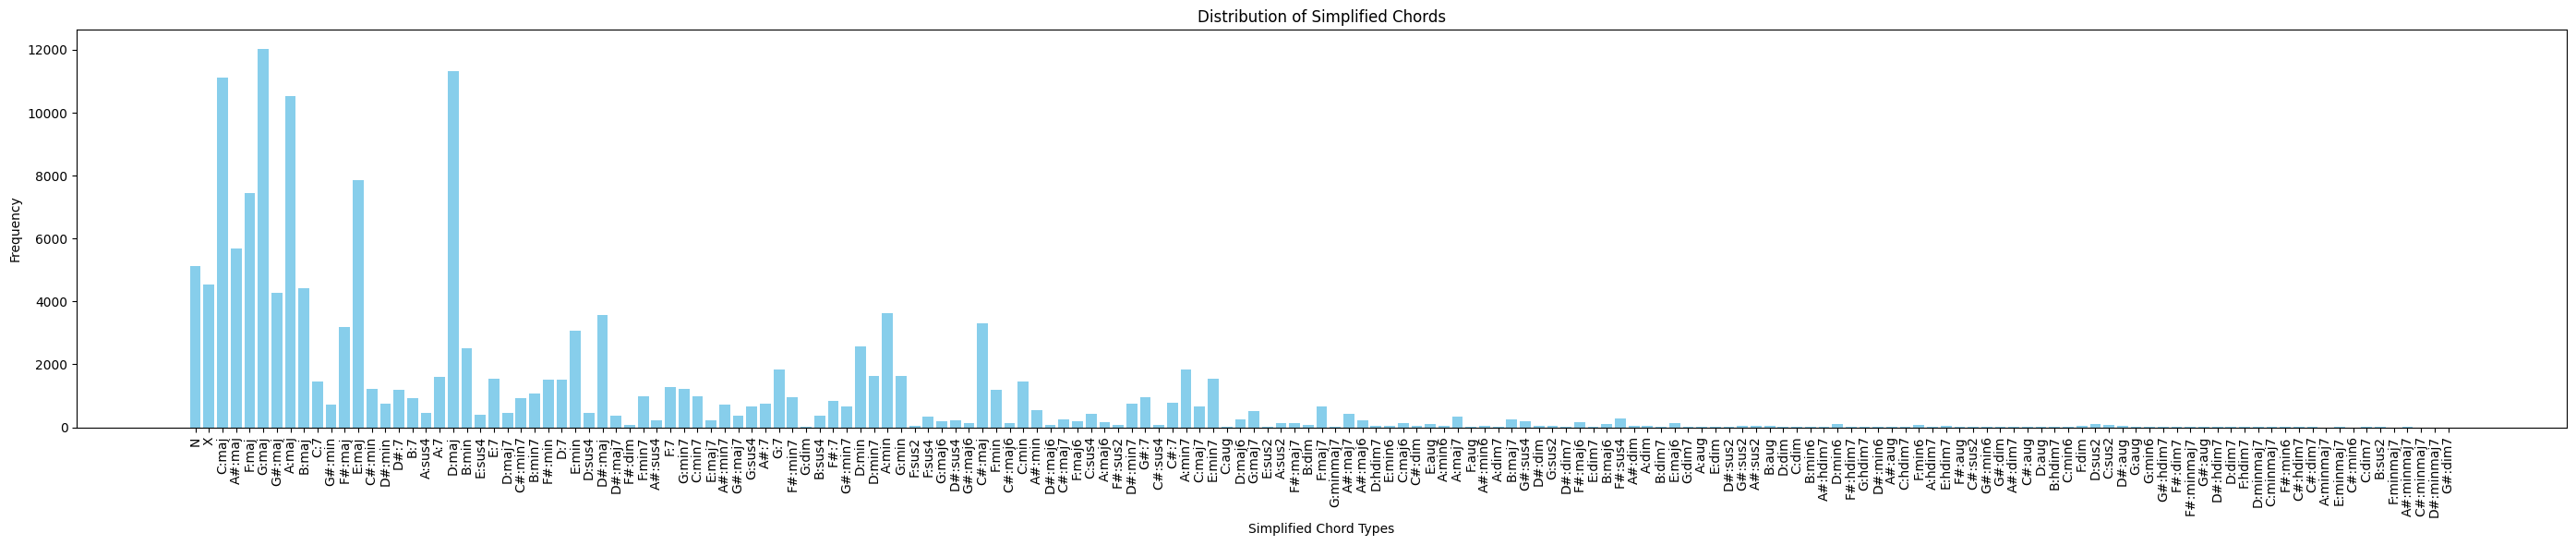

In [ ]:
simplified_chords = [simplify(chord) for chord in chords]
# Count the frequency of each simplified chord
simplified_chord_counter = Counter(simplified_chords)

# Extract chord types and their frequencies
chord_types = list(simplified_chord_counter.keys())
frequencies = list(simplified_chord_counter.values())

# Plot the histogram
plt.figure(figsize=(28, 6))
plt.bar(chord_types, frequencies, color="skyblue")
plt.xlabel("Simplified Chord Types")
plt.ylabel("Frequency")
plt.title("Distribution of Simplified Chords")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [61]:
def plot_simplified_chord_notes_distribution(simplified_chords):
    simplified_chord_notes = [
        chord.split(":")[0]
        for chord in simplified_chords
        if chord not in ["N", "X"]
    ]
    # Count the frequency of each simplified chord
    simplified_chord_counter = Counter(simplified_chord_notes)

    # Extract chord types and their frequencies
    chord_types = list(simplified_chord_counter.keys())
    frequencies = list(simplified_chord_counter.values())

    # Plot the histogram
    plt.figure(figsize=(12, 6))
    bars = plt.bar(chord_types, frequencies, color="skyblue")
    plt.xlabel("Simplified Chord Notes")
    plt.ylabel("Frequency")
    plt.title("Distribution of Simplified Chord Notes")
    plt.tight_layout()

    # Add frequency numbers on top of each bar
    for bar, freq in zip(bars, frequencies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(freq),
            ha="center",
            va="bottom",
        )

    plt.show()

In [62]:
def plot_simplified_chord_types_distribution(simplified_chords):
    simplified_chord_types = [
        chord.split(":")[1]
        for chord in simplified_chords
        if chord not in ["N", "X"]
    ]
    # Count the frequency of each simplified chord
    simplified_chord_counter = Counter(simplified_chord_types)

    # Extract chord types and their frequencies
    chord_types = list(simplified_chord_counter.keys())
    frequencies = list(simplified_chord_counter.values())

    # Plot the histogram
    plt.figure(figsize=(12, 6))
    bars = plt.bar(chord_types, frequencies, color="skyblue")
    plt.xlabel("Simplified Chord Types")
    plt.ylabel("Frequency")
    plt.title("Distribution of Simplified Chord Types")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add frequency numbers on top of each bar
    for bar, freq in zip(bars, frequencies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(freq),
            ha="center",
            va="bottom",
        )

    plt.show()

In [56]:
folder_path = "/Users/theo/School/2/MIR/final-project/chord_progression_generator/data/jams"  # "/Users/theo/School/2/MIR/final-project/datasets/Andrea/annotations"
# "/Users/theo/School/2/MIR/final-project/chord_progression_generator/data/jams"

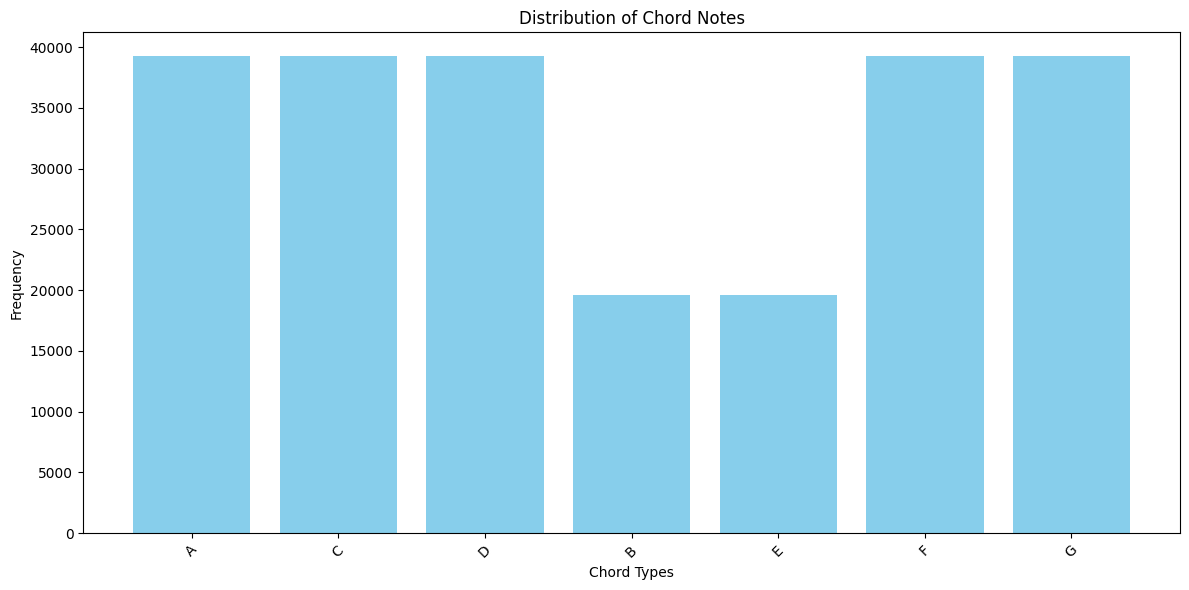

In [57]:
plot_chord_type_distribution(folder_path)

In [ ]:
chords = process_chord_annotations(folder_path)

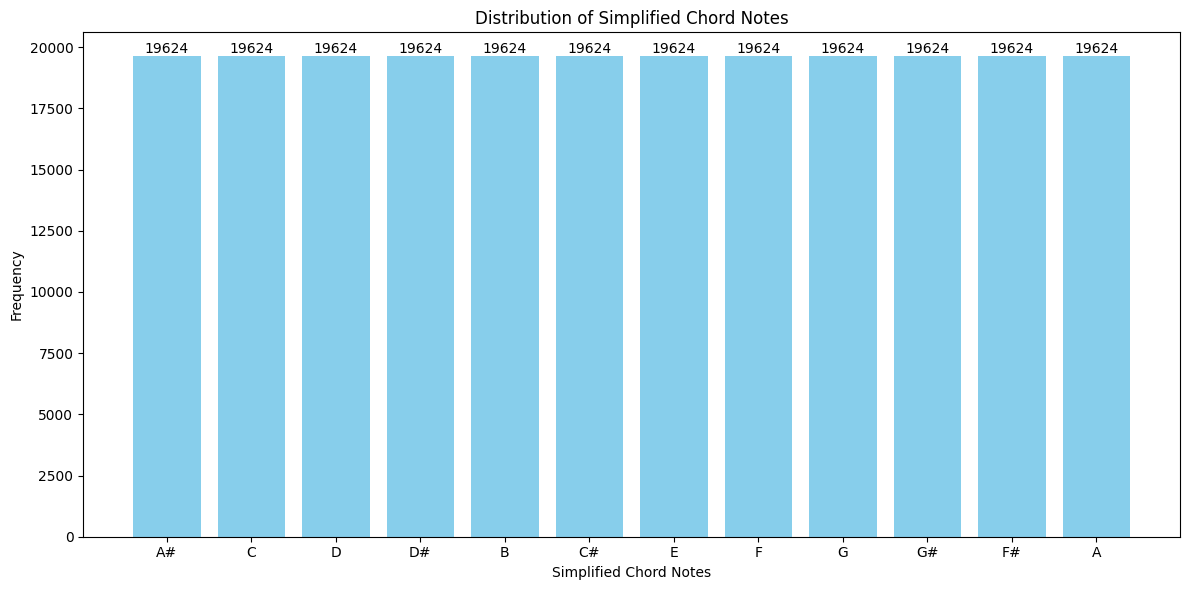

In [ ]:
plot_simplified_chord_notes_distribution(chords)

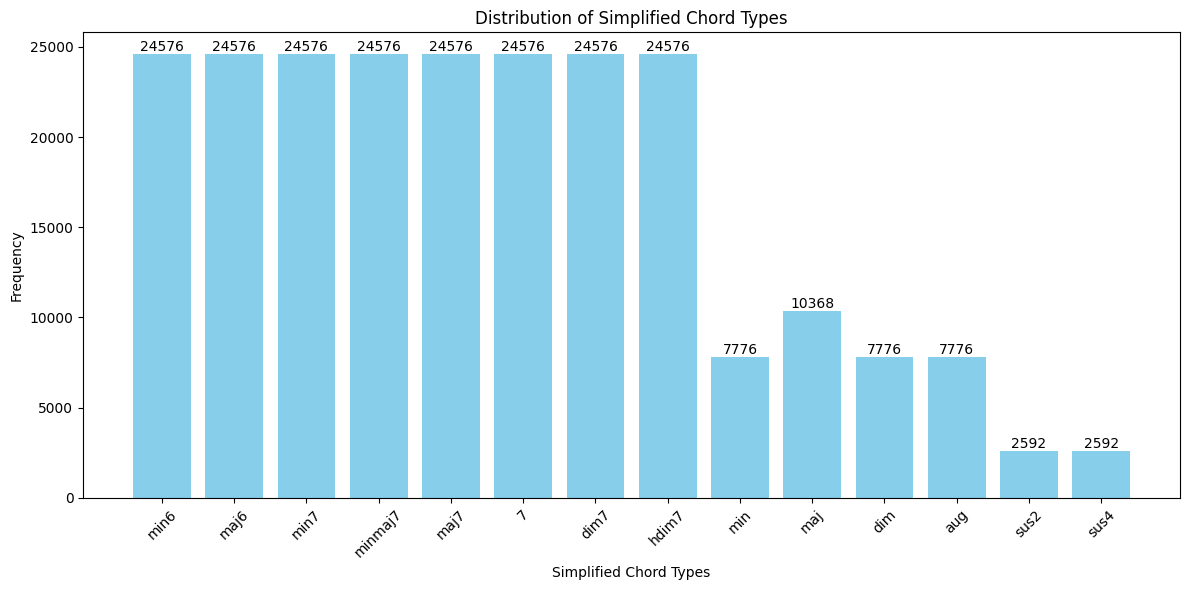

In [64]:
plot_simplified_chord_types_distribution(chords)